In [1]:
## Load everything!

import numpy as np
import h5py
import time
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from scipy.optimize import curve_fit
from chillyinductor.rp22_helper import *
from colorama import Fore, Style
import sys
import os
import pandas as pd

#------------------------------------------------------------
# Import Data
datapath = get_datadir_path(rp=22, smc='A')
if datapath is None:
	print(f"{Fore.RED}Failed to find data location{Style.RESET_ALL}")
	sys.exit()
else:
	print(f"{Fore.GREEN}Located data directory at: {Fore.LIGHTBLACK_EX}{datapath}{Style.RESET_ALL}")
filename = "dMS4_t2_10June2024_r1.hdf"

analysis_file = os.path.join(datapath, filename)

USE_CONST_SCALE = True

##--------------------------------------------
# Read HDF5 File

t_hdfr_0 = time.time()
with h5py.File(analysis_file, 'r') as fh:
	
	READ_MODE = 'dataset'
	df_cond_dict = {'powermeter_dBm': fh[READ_MODE]['coupled_power_meas_dBm'],
			 'rf_enabled': fh[READ_MODE]['rf_enabled'],
			 'lo_enabled': fh[READ_MODE]['lo_enabled'],
			 'freq_rf_GHz': fh[READ_MODE]['freq_rf_GHz'],
			 'freq_lo_GHz': fh[READ_MODE]['freq_lo_GHz'],
			 'power_rf_dBm': fh[READ_MODE]['power_RF_dBm'],
			 'power_lo_dBm': fh[READ_MODE]['power_LO_dBm'],
			 'DC_current_est_V': fh[READ_MODE]['DC_current_est_V'],
			 'output_set_voltage_V': fh[READ_MODE]['output_set_voltage_V'],
			 'target_DC_current_mA': fh[READ_MODE]['target_DC_current_mA'],
			 }
	df_sa_dict = {'wav_f_Hz': list(fh[READ_MODE]['waveform_f_Hz']),
			 'wav_s_dBm': list(fh[READ_MODE]['waveform_s_dBm']),
			 'wav_rbw_Hz': list(fh[READ_MODE]['waveform_rbw_Hz']),
			 }
	
	READ_MODE = 'calibration_data'
	cf_cond_dict = {'powermeter_dBm': fh[READ_MODE]['coupled_power_meas_dBm'],
			 'rf_enabled': fh[READ_MODE]['rf_enabled'],
			 'lo_enabled': fh[READ_MODE]['lo_enabled'],
			 'freq_rf_GHz': fh[READ_MODE]['freq_rf_GHz'],
			 'freq_lo_GHz': fh[READ_MODE]['freq_lo_GHz'],
			 'power_rf_dBm': fh[READ_MODE]['power_RF_dBm'],
			 'power_lo_dBm': fh[READ_MODE]['power_LO_dBm']
			 }
	cf_sa_dict = {'wav_f_Hz': list(fh[READ_MODE]['waveform_f_Hz']),
			 'wav_s_dBm': list(fh[READ_MODE]['waveform_s_dBm']),
			 'wav_rbw_Hz': list(fh[READ_MODE]['waveform_rbw_Hz']),
			 }
	
	# Load configuration data
	dataset_config = json.loads(fh['info']['configuration'][()].decode())
	
	# Create calibration data dataframes
	cf_cond = pd.DataFrame(cf_cond_dict)
	cf_sa = pd.DataFrame(cf_sa_dict)
	
	# Create dataset dataframes
	df_cond = pd.DataFrame(df_cond_dict)
	df_sa = pd.DataFrame(df_sa_dict)
	
	# Trim values greater than 10e3
	X = 10e3
	I_match = (df_cond <= X).all(axis=1)
	df_cond = df_cond[I_match]
	df_sa = df_sa[I_match]
	I_match = (cf_cond <= X).all(axis=1)
	cf_cond = cf_cond[I_match]
	cf_sa = cf_sa[I_match]

R_sense = dataset_config['curr_sense_ohms']

# Create new column for estimated bias current
Ibias_raw =  df_cond.DC_current_est_V/R_sense*1e3
Ibias_bin = bin_empirical(Ibias_raw)
df_cond.insert(len(df_cond.columns), 'Ibias_mA', Ibias_raw)
df_cond.insert(len(df_cond.columns), 'Ibias_mA_bin', Ibias_bin)

# Calculate mixing data DF
df_mix = calc_mixing_data(df_cond, df_sa)

# Print some stats
print(f"{Fore.YELLOW}DF_COND:{Style.RESET_ALL}")
print(df_cond)
print(f"{Fore.YELLOW}DF_SA:{Style.RESET_ALL}")
print(df_sa)

Located data directory at: G:\ARC0 PhD Data\RP-22 Mixing + C2024 Upconv\Data\SMC-A Downconversion v1
DF_COND:
     powermeter_dBm  rf_enabled  lo_enabled  freq_rf_GHz  freq_lo_GHz  \
0         -15.20996        True        True          2.5         0.10   
1         -15.11969        True        True          2.5         0.15   
2         -15.00248        True        True          2.5         0.20   
3         -14.88031        True        True          2.5         0.25   
4         -14.72800        True        True          2.5         0.30   
..              ...         ...         ...          ...          ...   
724       -14.15377        True        True          4.5         0.30   
725       -14.00207        True        True          4.5         0.35   
726       -13.86815        True        True          4.5         0.40   
727       -13.72985        True        True          4.5         0.45   
728       -13.53230        True        True          4.5         0.50   

     power_rf

mean diff = 0.012914548121233606
max diff = 1.1944335483870976


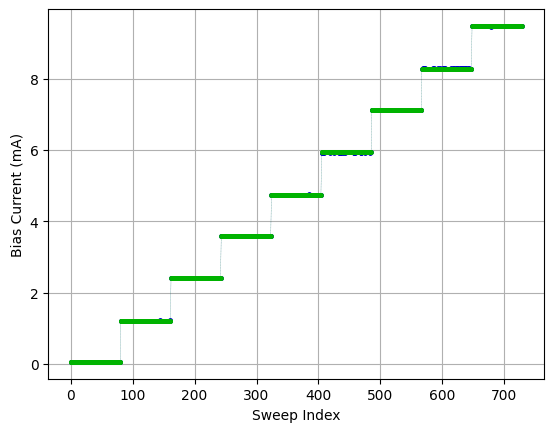

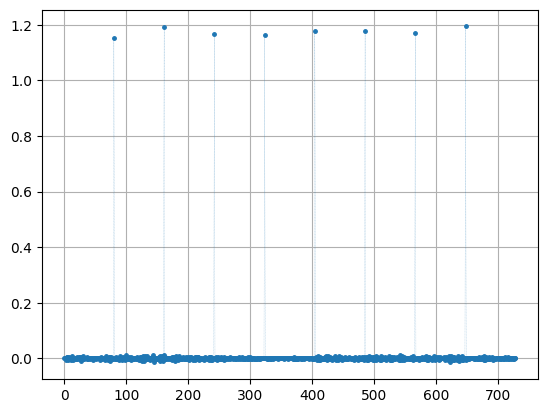

In [2]:
## Plot bias currents


plt.figure(1)
plt.plot(df_cond.Ibias_mA, marker='.', markersize=5, linestyle=':', linewidth=0.2, color=(0, 0, 0.8))
plt.plot(Ibias_bin, marker='.', markersize=5, linestyle=':', linewidth=0.2, color=(0, 0.7, 0))
plt.grid(True)
plt.xlabel("Sweep Index")
plt.ylabel("Bias Current (mA)")

plt.figure(2)
plt.plot(np.diff(df_cond.Ibias_mA), marker='.', markersize=5, linestyle=':', linewidth=0.2)
plt.grid(True)

print(f"mean diff = {np.mean(np.diff(df_cond.Ibias_mA))}")
print(f"max diff = {np.max(np.diff(df_cond.Ibias_mA))}")

plt.show()


### Plot surface graphs of the spectral components and their dependencies on LO and RF frequencies

Now we can see each product in freq-freq space

In [4]:
## Make graphs of each power level

# Deploy ipython magic to get the graphs windowed rather than inline
%matplotlib notebook

X,Y,Zmx1l = dfplot3d(df_mix, xparam='freq_rf_GHz', yparam='freq_lo_GHz', zparam='peak_mx1l', fixedparam={'Ibias_mA':(0, 0, 0.2)}, skip_plot=False, fig_no=1, show_markers=True, hovertips=False)
X,Y,Zrf1 = dfplot3d(df_mix, xparam='freq_rf_GHz', yparam='freq_lo_GHz', zparam='peak_rf1', fixedparam={'Ibias_mA':(0, 0, 0.2)}, skip_plot=False, fig_no=2, show_markers=True, hovertips=False)
X,Y,Zlo1 = dfplot3d(df_mix, xparam='freq_rf_GHz', yparam='freq_lo_GHz', zparam='peak_lo1', fixedparam={'Ibias_mA':(0, 0, 0.2)}, skip_plot=False, fig_no=3, show_markers=True, hovertips=False)

X,Y,Zmx1h = dfplot3d(df_mix, xparam='freq_rf_GHz', yparam='freq_lo_GHz', zparam='peak_mx1h', fixedparam={'Ibias_mA':(0, 0, 0.2)}, skip_plot=False, fig_no=4, show_markers=True, hovertips=False)
X,Y,Zmx2l = dfplot3d(df_mix, xparam='freq_rf_GHz', yparam='freq_lo_GHz', zparam='peak_mx2l', fixedparam={'Ibias_mA':(0, 0, 0.2)}, skip_plot=False, fig_no=5, show_markers=True, hovertips=False)
X,Y,Zmx2h = dfplot3d(df_mix, xparam='freq_rf_GHz', yparam='freq_lo_GHz', zparam='peak_mx2h', fixedparam={'Ibias_mA':(0, 0, 0.2)}, skip_plot=False, fig_no=6, show_markers=True, hovertips=False)

## Make graphs of mixing loss (X=f_rf, Y=f_lo)
lplot3d(X, Y, Zmx1l-Zrf1, xparam='freq_rf_GHz', yparam='freq_lo_GHz', zparam='mx1l-rf1', fig_no=7, show_markers=True, hovertips=False)

plt.show()
?%matplotlib


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Docstring:
::

  %matplotlib [-l] [gui]

Set up matplotlib to work interactively.

This function lets you activate matplotlib interactive support
at any point during an IPython session. It does not import anything
into the interactive namespace.

If you are using the inline matplotlib backend in the IPython Notebook
you can set which figure formats are enabled using the following::

    In [1]: from matplotlib_inline.backend_inline import set_matplotlib_formats

    In [2]: set_matplotlib_formats('pdf', 'svg')

The default for inline figures sets `bbox_inches` to 'tight'. This can
cause discrepancies between the displayed image and the identical
image created using `savefig`. This behavior can be disabled using the
`%config` magic::

    In [3]: %config InlineBackend.print_figure_kwargs = {'bbox_inches':None}

In addition, see the docstrings of
`matplotlib_inline.backend_inline.set_matplotlib_formats` and
`matplotlib_inline.backend_inline.set_matplotlib_close` for more information on
c

### Plot surface graphs in (Bias-LO):Space

This is what we've all been waiting for!

In [ ]:
## Make a graph of mixing loss (Fix: f_rf, X=bias, Y=f_lo)

X,Y,Zmx1l = dfplot3d(df_mix, xparam='Ibias_mA_bin', yparam='freq_lo_GHz', zparam='peak_mx1l', fixedparam={'freq_rf_GHz':(4, 0, 0.1)}, skip_plot=False, fig_no=1, show_markers=True, hovertips=False)
X,Y,Zmx1h = dfplot3d(df_mix, xparam='Ibias_mA_bin', yparam='freq_lo_GHz', zparam='peak_mx1l', fixedparam={'freq_rf_GHz':(4, 0, 0.1)}, skip_plot=False, fig_no=2, show_markers=True, hovertips=False)
X,Y,Zmx2l = dfplot3d(df_mix, xparam='Ibias_mA_bin', yparam='freq_lo_GHz', zparam='peak_mx2l', fixedparam={'freq_rf_GHz':(4, 0, 0.1)}, skip_plot=False, fig_no=3, show_markers=True, hovertips=False)
X,Y,Zmx2h = dfplot3d(df_mix, xparam='Ibias_mA_bin', yparam='freq_lo_GHz', zparam='peak_mx2h', fixedparam={'freq_rf_GHz':(4, 0, 0.1)}, skip_plot=False, fig_no=4, show_markers=True, hovertips=False)
X,Y,Zrf1 = dfplot3d(df_mix, xparam='Ibias_mA_bin', yparam='freq_lo_GHz', zparam='peak_rf1', fixedparam={'freq_rf_GHz':(4, 0, 0.1)}, skip_plot=False, fig_no=5, show_markers=True, hovertips=False)

lplot3d(X, Y, Zmx1l-Zrf1, xparam='Ibias_mA_bin', yparam='freq_lo_GHz', zparam='mx1l-rf1', fig_no=7, show_markers=True, hovertips=False)
lplot3d(X, Y, Zmx1h-Zrf1, xparam='Ibias_mA_bin', yparam='freq_lo_GHz', zparam='mx1h-rf1', fig_no=8, show_markers=True, hovertips=False)

lplot3d(X, Y, Zmx2l-Zrf1, xparam='Ibias_mA_bin', yparam='freq_lo_GHz', zparam='mx2l-rf1', fig_no=9, show_markers=True, hovertips=False)
lplot3d(X, Y, Zmx2h-Zrf1, xparam='Ibias_mA_bin', yparam='freq_lo_GHz', zparam='mx2h-rf1', fig_no=10, show_markers=True, hovertips=False)
